In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

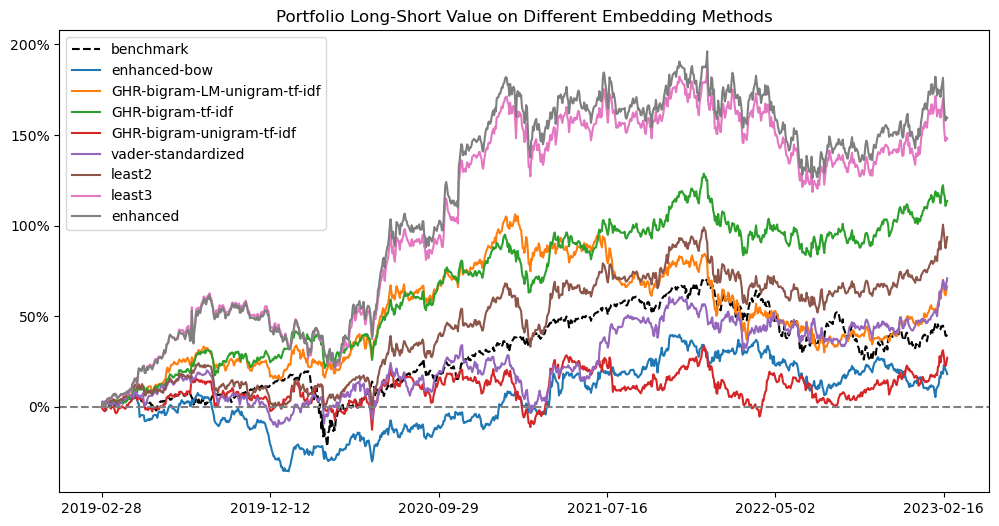

In [66]:
import os
import matplotlib.dates as mdates
path = 'data/portfolio_decile_value'
file_lt = os.listdir(path)
fig = plt.figure(figsize=(12,6))
return_df = pd.DataFrame()
portfolio_performance = {}

# calculate the benchmark(SP500 - Risk Free asset)
start_date = '2019-03-01'
SP500 = pd.read_csv('data/SP500_daily.csv')
SP500 = SP500.iloc[SP500[SP500['Date'] == start_date].index[0]-1:]
SP500['Adj Close'] = SP500['Adj Close'] / SP500['Adj Close'].iloc[0]

ff_dt = 'data/F-F_Research_Data_Factors_daily.CSV'
ff = pd.read_csv(ff_dt)
ff.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
start_date = '2019-03-01'
end_date = '2023-02-23'
start_index = ff[ff['Date'] == start_date].index[0]-1
end_index = ff[ff['Date'] == end_date].index[0]
ff = ff.iloc[start_index:end_index+1]

benchmark = pd.merge(SP500[['Date','Adj Close']], ff[['Date','RF']], how='right', on='Date')
benchmark['RF'] = benchmark['RF'] / 100
benchmark.iloc[0,2] = 0
benchmark['RF cum'] = (1 + benchmark['RF']).cumprod()
benchmark['Benchmark'] = benchmark['Adj Close'] - benchmark['RF cum']
benchmark['daily_return'] = benchmark['Benchmark'].diff()
portfolio_performance['Benchmark'] = [(np.nanmean(benchmark['daily_return']) +1)**252 -1, np.nanstd(benchmark['daily_return']) * np.sqrt(252),0]
plt.plot(benchmark['Date'], benchmark['Benchmark'], label='benchmark', color='black', linestyle='--')

# calculate the return of the portfolio
for j in range(len(file_lt)):
    file = path + '/' + file_lt[j]
    df = pd.read_csv(file)
    decile_rows = df[df['Unnamed: 0'] == 'decile']
    decile_values = decile_rows['0'].tolist()

    output_df = pd.DataFrame()
    for i, value in enumerate(decile_values):
        if i == 0:
            decile_df = df.iloc[:decile_rows.index[i]]
            decile_df.columns = ['Date', str(int(value))]
            output_df = decile_df.copy(deep=True)
        elif i == len(decile_values)-1:
            decile_df = df.iloc[decile_rows.index[i-1]+1:]
            decile_df.columns = ['Date', str(int(value))]
            output_df = pd.merge(output_df, decile_df, how='left', on='Date')
        else:
            decile_df = df.iloc[decile_rows.index[i-1]+1:decile_rows.index[i]]
            decile_df.columns = ['Date', str(int(value))]
            output_df = pd.merge(output_df, decile_df, how='left', on='Date')
    output_df['portfolio'] = output_df['1'] + output_df['2'] - output_df['10'] - output_df['9']
    if j == 0:
        return_df = output_df[['Date', 'portfolio']]
        return_df.columns = ['Date', file_lt[j].split('.')[0].split('_')[-1]]
    else:
        return_df[file_lt[j].split('.')[0].split('_')[-1]] = output_df['portfolio']
    #print(file_lt[j])
    new_df = pd.DataFrame({'Date':'2019-02-28','1':1,'2':1,'3':1,'4':1,'5':1,'6':1,'7':1,'8':1,'9':1,'10':1,'portfolio':0},index=[0])
    output_df = pd.concat([new_df,output_df], ignore_index=True)
    output_df['Daily_return'] = output_df['portfolio'].diff()
    te = np.nanstd(output_df['Daily_return'] - benchmark['daily_return']) * np.sqrt(252)
    portfolio_performance[file_lt[j].split('.')[0].split('_')[-1]] = [(np.nanmean(output_df['Daily_return'])+1) ** 252 -1, np.nanstd(output_df['Daily_return']) * np.sqrt(252), te]
    plt.plot(output_df['Date'], output_df['portfolio'], label=file_lt[j].split('.')[0].split('_')[-1])


import matplotlib.ticker as mtick
ax = plt.gca()
    # 设置y轴标签为百分比
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # 添加y = 0处的虚线
ax.axhline(y=0, color='gray', linestyle='dashed')

    # 显示图形
plt.xticks(output_df['Date'][::200])
plt.title('Portfolio Long-Short Value on Different Embedding Methods')
plt.legend()
plt.show()
fig.savefig('data/portfolio_decile_vis/Portfolio_Long_Short_Value.png')

In [92]:
summary_df = pd.DataFrame(portfolio_performance).T
summary_df.columns = ['Annual Return', 'Annual Volatility','Tracking Error']
mean_rf = (benchmark['RF'].mean() + 1)**252 -1
summary_df['Sharpe Ratio'] = (summary_df['Annual Return'] - mean_rf) / summary_df['Annual Volatility']
summary_df['CAR'] = summary_df['Annual Return'] - portfolio_performance['Benchmark'][0]
summary_df['information ratio'] = summary_df['CAR'] / summary_df['Tracking Error']

In [93]:
summary_df.sort_values(by='Annual Return', ascending=True, inplace=True)

In [94]:
summary_df

,Annual Return,Annual Volatility,Tracking Error,Sharpe Ratio,CAR,information ratio
enhanced-bow,0.046232,0.254262,0.344036,0.140421,-0.058886,-0.171161
GHR-bigram-unigram-tf-idf,0.070234,0.282376,0.380019,0.211438,-0.034884,-0.091796
Benchmark,0.105118,0.277122,0.000000,0.341328,0.000000,NaN
GHR-bigram-LM-unigram-tf-idf,0.181353,0.327587,0.345001,0.521462,0.076235,0.220969
vader-standardized,0.194768,0.299040,0.359846,0.616104,0.089650,0.249135
least2,0.264950,0.322431,0.336595,0.789072,0.159832,0.474851
GHR-bigram-tf-idf,0.329760,0.324316,0.301015,0.984323,0.224642,0.746283
least3,0.448886,0.522254,0.463454,0.839356,0.343768,0.741752
enhanced,0.491182,0.536637,0.472497,0.895676,0.386064,0.817072


In [95]:
summary_df.to_csv('data/strategy_performance.csv')
summary_df.drop('Benchmark', inplace=True)

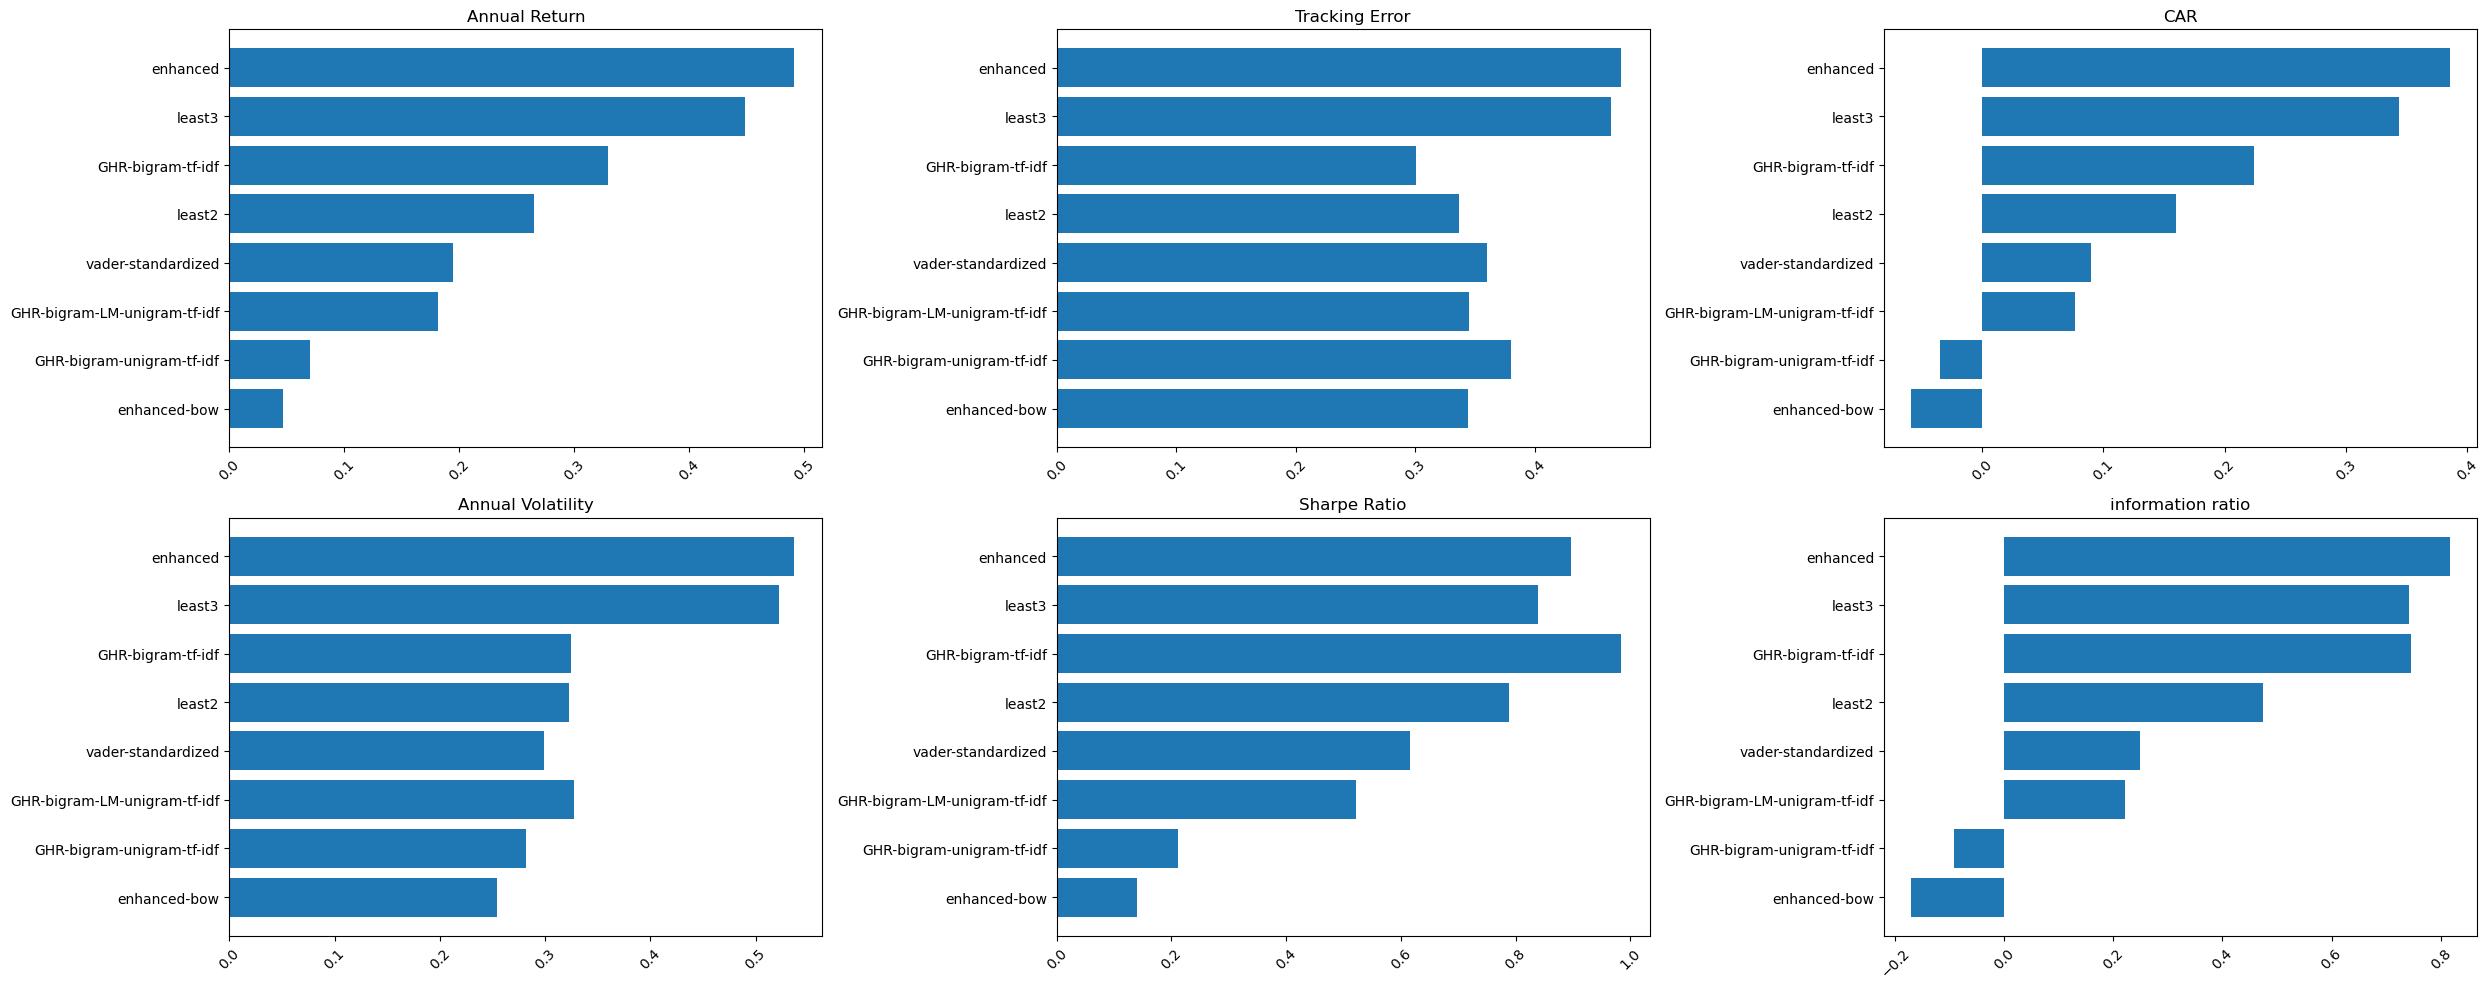

In [102]:
fig, ax = plt.subplots(2,3, figsize=(25,10))
for i, col in enumerate(summary_df.columns):
    co = i % 2
    row = i // 2
    ax[co,row].barh(summary_df.index, summary_df[col])
    ax[co,row].set_title(col)
    for label in ax[co,row].get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()
fig.savefig('data/portfolio_decile_vis/Portfoliio_summary.png')


We experiment with the Fama-French data. This was not included in the report as we deemed it outside of the project scope.

In [ ]:
daily_returns = return_df.set_index("Date").diff().dropna().reset_index()
daily_returns = pd.concat([pd.DataFrame(return_df.iloc[0,:]).T, daily_returns],ignore_index=True)

In [40]:
daily_returns.to_csv('data/portfolio_daily_return.csv', index=False)

In [44]:
merged_df = pd.merge(daily_returns, ff, how='left', on='Date')
merged_df[['Mkt-RF', 'SMB', 'HML', 'RF']] = merged_df[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100

In [50]:
import statsmodels.api as sm
X = merged_df[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)
portfolio = ['enhanced-bow','GHR-bigram-LM-unigram-tf-idf',	'GHR-bigram-tf-idf','GHR-bigram-unigram-tf-idf','vader-standardized']

In [52]:
print('Portfolio:', portfolio[0])
y = merged_df[portfolio[0]]
model = sm.OLS(y.astype(float), X.astype(float)).fit()
print(model.summary())

Portfolio: enhanced-bow
                            OLS Regression Results                            
Dep. Variable:           enhanced-bow   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     21.31
Date:                Sun, 19 May 2024   Prob (F-statistic):           2.20e-13
Time:                        19:26:30   Log-Likelihood:                 2757.1
No. Observations:                1004   AIC:                            -5506.
Df Residuals:                    1000   BIC:                            -5487.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0

In [53]:
print('Portfolio:', portfolio[1])
y = merged_df[portfolio[1]]
model = sm.OLS(y.astype(float), X.astype(float)).fit()
print(model.summary())

Portfolio: GHR-bigram-LM-unigram-tf-idf
                                 OLS Regression Results                                 
Dep. Variable:     GHR-bigram-LM-unigram-tf-idf   R-squared:                       0.372
Model:                                      OLS   Adj. R-squared:                  0.371
Method:                           Least Squares   F-statistic:                     197.8
Date:                          Sun, 19 May 2024   Prob (F-statistic):          1.04e-100
Time:                                  19:26:42   Log-Likelihood:                 2705.5
No. Observations:                          1004   AIC:                            -5403.
Df Residuals:                              1000   BIC:                            -5383.
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    

In [54]:
print('Portfolio:', portfolio[2])
y = merged_df[portfolio[2]]
model = sm.OLS(y.astype(float), X.astype(float)).fit()
print(model.summary())

Portfolio: GHR-bigram-tf-idf
                            OLS Regression Results                            
Dep. Variable:      GHR-bigram-tf-idf   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     138.9
Date:                Sun, 19 May 2024   Prob (F-statistic):           3.10e-75
Time:                        19:26:49   Log-Likelihood:                 2656.6
No. Observations:                1004   AIC:                            -5305.
Df Residuals:                    1000   BIC:                            -5286.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009  

In [55]:
print('Portfolio:', portfolio[3])
y = merged_df[portfolio[3]]
model = sm.OLS(y.astype(float), X.astype(float)).fit()
print(model.summary())

Portfolio: GHR-bigram-unigram-tf-idf
                                OLS Regression Results                               
Dep. Variable:     GHR-bigram-unigram-tf-idf   R-squared:                       0.016
Model:                                   OLS   Adj. R-squared:                  0.013
Method:                        Least Squares   F-statistic:                     5.317
Date:                       Sun, 19 May 2024   Prob (F-statistic):            0.00123
Time:                               19:26:56   Log-Likelihood:                 2628.7
No. Observations:                       1004   AIC:                            -5249.
Df Residuals:                           1000   BIC:                            -5230.
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [56]:
print('Portfolio:', portfolio[4])
y = merged_df[portfolio[4]]
model = sm.OLS(y.astype(float), X.astype(float)).fit()
print(model.summary())

Portfolio: vader-standardized
                            OLS Regression Results                            
Dep. Variable:     vader-standardized   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     168.5
Date:                Sun, 19 May 2024   Prob (F-statistic):           2.04e-88
Time:                        19:27:02   Log-Likelihood:                 2768.6
No. Observations:                1004   AIC:                            -5529.
Df Residuals:                    1000   BIC:                            -5510.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006 

Next, we attempt to create long-short portfolios that ensemble the sentiment scores by demanding that they firms are placed in 3 other underlying sentiment decile portfolios. This was not included in the report as we were worried about selection bias. If we superimpose their performance on the other long-short-portfolios, these have far stronger performance.

In [12]:
df = pd.DataFrame(pd.read_pickle('data/portfolio_decile/portfolio_dict_enhanced-bow.pkl')).T.reset_index()

In [23]:
import os
port_list = os.listdir('data/portfolio_decile')
for port in port_list:
    df = pd.DataFrame(pd.read_pickle('data/portfolio_decile/'+port)).T.reset_index()
    for i,row in df.iterrows():
        lth = len(row['ticker'])
        if i == 0:
            check_1 = set(row['ticker'][:int(lth/10)])
            print(check_1)
            check_2 = set(row['ticker'][int(lth/10):2*int(lth/10)])
            check_9 = set(row['ticker'][-2*int(lth/10):-int(lth/10)])
            check_10 = set(row['ticker'][-int(lth/10):])
        else:
            check_1 = check_1.intersection(set(row['ticker'][:int(lth/10)]))
            check_2 = check_2.intersection(set(row['ticker'][int(lth/10):2*int(lth/10)]))
            check_9 = check_9.intersection(set(row['ticker'][-2*int(lth/10):-int(lth/10)]))
            check_10 = check_10.intersection(set(row['ticker'][-int(lth/10):]))
    print(f"{port}, first decile: {check_1},second: {check_2}, bottom second {check_9}, bottom first: {check_10}")

{'BERY', 'LYV', 'SPXC', 'TEX', 'DAN', 'BYD', 'OSPN', 'EA', 'PSA', 'MSA', 'BBU', 'MAT'}
portfolio_dict_enhanced-bow.pkl, first decile: set(),second: set(), bottom second set(), bottom first: set()
{'CSL', 'SPSC', 'LYV', 'LQDT', 'KN', 'BYD', 'CRVL', 'NMIH', 'JRVR', 'CSGS', 'DIN', 'JBT'}
portfolio_dict_GHR-bigram-LM-unigram-tf-idf.pkl, first decile: set(),second: set(), bottom second set(), bottom first: set()
{'FN', 'CSL', 'HBI', 'OMCL', 'TILE', 'KN', 'BYD', 'CRVL', 'NMIH', 'JRVR', 'RDWR', 'CSGS'}
portfolio_dict_GHR-bigram-tf-idf.pkl, first decile: set(),second: set(), bottom second set(), bottom first: set()
{'FN', 'CSL', 'SPSC', 'LQDT', 'OMCL', 'TILE', 'KN', 'CRVL', 'SPH', 'NMIH', 'CSGS', 'ALTR'}
portfolio_dict_GHR-bigram-unigram-tf-idf.pkl, first decile: set(),second: set(), bottom second set(), bottom first: set()
{'BERY', 'SPSC', 'GOOGL', 'HBI', 'FOXF', 'KN', 'BYD', 'BRKR', 'MSA', 'CUZ', 'DIN'}
portfolio_dict_vader-standardized.pkl, first decile: set(),second: set(), bottom second s

In [110]:
df_0 = pd.DataFrame(pd.read_pickle(f'data/portfolio_decile/'+port_list[0])).T.reset_index()
df_1 = pd.DataFrame(pd.read_pickle(f'data/portfolio_decile/'+port_list[1])).T.reset_index()
df_2 = pd.DataFrame(pd.read_pickle(f'data/portfolio_decile/'+port_list[2])).T.reset_index()
df_3 = pd.DataFrame(pd.read_pickle(f'data/portfolio_decile/'+port_list[3])).T.reset_index()
df_4 = pd.DataFrame(pd.read_pickle(f'data/portfolio_decile/'+port_list[4])).T.reset_index()
def get_good_ticker(ticker_list):
    first_dict = {}
    for i in ticker_list:
        if i in first_dict:
            first_dict[i] += 1
        else:
            first_dict[i] = 1
    filtered_dict = {key: value for key, value in first_dict.items() if value > 2}
    return list(filtered_dict.keys()), list(filtered_dict.values())
    #print(filtered_dict.keys())
new_df = pd.DataFrame()
for i,row in df_0.iterrows():
    lth = len(row['ticker'])
    #print(lth//10)
    first_list = df_0.iloc[i]['ticker'][:int(lth/10)] + df_1.iloc[i]['ticker'][:int(lth/10)] \
            + df_2.iloc[i]['ticker'][:int(lth/10)] + df_3.iloc[i]['ticker'][:int(lth/10)] + df_4.iloc[i]['ticker'][:int(lth/10)]
    second_list = df_0.iloc[i]['ticker'][int(lth/10):2*int(lth/10)] + df_1.iloc[i]['ticker'][int(lth/10):2*int(lth/10)] \
            + df_2.iloc[i]['ticker'][int(lth/10):2*int(lth/10)] + df_3.iloc[i]['ticker'][int(lth/10):2*int(lth/10)] + df_4.iloc[i]['ticker'][int(lth/10):2*int(lth/10)]
    bottom_second_list = df_0.iloc[i]['ticker'][-2*int(lth/10):-int(lth/10)] + df_1.iloc[i]['ticker'][-2*int(lth/10):-int(lth/10)] \
            + df_2.iloc[i]['ticker'][-2*int(lth/10):-int(lth/10)] + df_3.iloc[i]['ticker'][-2*int(lth/10):-int(lth/10)] + df_4.iloc[i]['ticker'][-2*int(lth/10):-int(lth/10)]
    bottom_first_list = df_0.iloc[i]['ticker'][-int(lth/10):] + df_1.iloc[i]['ticker'][-int(lth/10):] \
            + df_2.iloc[i]['ticker'][-int(lth/10):] + df_3.iloc[i]['ticker'][-int(lth/10):] + df_4.iloc[i]['ticker'][-int(lth/10):]
    first_port, first_count = get_good_ticker(first_list)
    second_port, second_count = get_good_ticker(second_list)
    bottom_second_port, bottom_second_count = get_good_ticker(bottom_second_list)
    bottom_first_port, bottom_first_count = get_good_ticker(bottom_first_list)
    #print(first_port)
    #print(second_port)
   # print(bottom_second_port)
    #print(bottom_first_port)
    #print(row['index'])
    new_df = pd.concat([new_df,pd.DataFrame({'index': row['index'], 'first': [first_port], 'second': [second_port], 'bottom_second': [bottom_second_port], 'bottom_first': [bottom_first_port],
                                             'first_count': [first_count], 'second_count': [second_count], 'bottom_second_count': [bottom_second_count], 'bottom_first_count': [bottom_first_count]})])
    #break

In [111]:
new_df.head(1)

,index,first,second,bottom_second,bottom_first,first_count,second_count,bottom_second_count,bottom_first_count
0,2019-03-01,"[BYD, CRVL, CSL, CSGS, KN, NMIH, SPSC]","[GOOGL, VRSK, SXC, RUSHA]","[LYB, ACCO, PBI, AXL, HR]","[NWE, OPI, GT, ALX, EIX, CWT]","[4, 3, 3, 3, 4, 3, 3]","[4, 3, 3, 4]","[3, 3, 3, 3, 3]","[3, 3, 3, 3, 3, 3]"


In [112]:
new_df.set_index('index', inplace=True)
for i,column in enumerate(['first', 'second', 'bottom_second', 'bottom_first']):
    new_df[f'{column}_decile'] = new_df[column].apply(lambda x: [i+1]*len(x) if i<2 else [i+7]*len(x))
    new_df[f'{column}_weight'] = new_df[f"{column}_count"].apply(lambda x: [i/sum(x) for i in x])

new_df.head(1)

,first,second,bottom_second,bottom_first,first_count,second_count,bottom_second_count,bottom_first_count,first_decile,first_weight,second_decile,second_weight,bottom_second_decile,bottom_second_weight,bottom_first_decile,bottom_first_weight
index,,,,,,,,,,,,,,,,
2019-03-01,"[BYD, CRVL, CSL, CSGS, KN, NMIH, SPSC]","[GOOGL, VRSK, SXC, RUSHA]","[LYB, ACCO, PBI, AXL, HR]","[NWE, OPI, GT, ALX, EIX, CWT]","[4, 3, 3, 3, 4, 3, 3]","[4, 3, 3, 4]","[3, 3, 3, 3, 3]","[3, 3, 3, 3, 3, 3]","[1, 1, 1, 1, 1, 1, 1]","[0.17391304347826086, 0.13043478260869565, 0.1...","[2, 2, 2, 2]","[0.2857142857142857, 0.21428571428571427, 0.21...","[9, 9, 9, 9, 9]","[0.2, 0.2, 0.2, 0.2, 0.2]","[10, 10, 10, 10, 10, 10]","[0.16666666666666666, 0.16666666666666666, 0.1..."


In [113]:
new_df['decile'] = new_df['first_decile'] + new_df['second_decile'] + new_df['bottom_second_decile'] + new_df['bottom_first_decile']
new_df['weight'] = new_df['first_weight'] + new_df['second_weight'] + new_df['bottom_second_weight'] + new_df['bottom_first_weight']
new_df['ticker'] = new_df['first'] + new_df['second'] + new_df['bottom_second'] + new_df['bottom_first']
new_df = new_df[['ticker','decile', 'weight']].T
new_df.to_pickle('data/portfolio_decile/portfolio_least3_enhanced.pkl')